In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras import datasets, layers, models, activations, Model, Input, regularizers
import keras
import warnings

warnings.filterwarnings('ignore')

2023-02-11 15:10:54.443325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-11 15:11:02.323589: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-11 15:11:02.323628: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-11 15:11:04.941165: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [2]:
from IPython.display import clear_output

!pip install -q tensorflow==2.4.1

clear_output()

In [3]:
BATCH_SIZE=32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database",
    seed=125,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    
)

Found 4200 files belonging to 2 classes.


2023-02-11 15:12:20.315730: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-11 15:12:20.315782: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-11 15:12:20.315822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3a0d8a3d87ba): /proc/driver/nvidia/version does not exist
2023-02-11 15:12:20.316434: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
class_names = dataset.class_names
class_names

['Normal', 'Tuberculosis']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0]


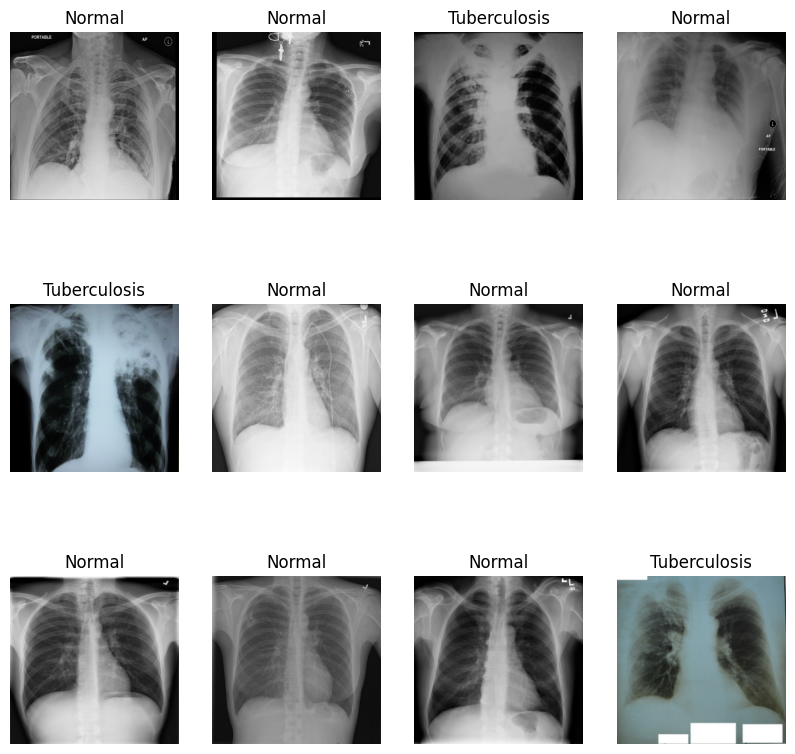

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [13]:
input_shape = (1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (1, 256, 256, 3)          0         
                                                                 
 conv2d (Conv2D)             (1, 254, 254, 32)         896       
                                                                 
 max_pooling2d (MaxPooling2D  (1, 127, 127, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (1, 125, 125, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (1, 62, 62, 64)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (1, 60, 60, 64)          

In [15]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=adam,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
92/92 [==============================] - 54s 555ms/step - loss: 0.4567 - accuracy: 0.8339 - val_loss: 0.4146 - val_accuracy: 0.8224
Epoch 2/50
92/92 [==============================] - 50s 542ms/step - loss: 0.3582 - accuracy: 0.8380 - val_loss: 0.2621 - val_accuracy: 0.8914
Epoch 3/50
92/92 [==============================] - 50s 541ms/step - loss: 0.1993 - accuracy: 0.9267 - val_loss: 0.3025 - val_accuracy: 0.8964
Epoch 4/50
92/92 [==============================] - 50s 543ms/step - loss: 0.1526 - accuracy: 0.9455 - val_loss: 0.1484 - val_accuracy: 0.9490
Epoch 5/50
92/92 [==============================] - 50s 544ms/step - loss: 0.1331 - accuracy: 0.9551 - val_loss: 0.1505 - val_accuracy: 0.9474
Epoch 6/50
92/92 [==============================] - 50s 548ms/step - loss: 0.1227 - accuracy: 0.9568 - val_loss: 0.1195 - val_accuracy: 0.9474
Epoch 7/50
92/92 [==============================] - 51s 552ms/step - loss: 0.1157 - accuracy: 0.9613 - val_loss: 0.1139 - val_accuracy: 0.9572

In [17]:
scores = model.evaluate(test_ds)

21/21 [==============================] - 3s 93ms/step - loss: 0.0098 - accuracy: 0.9970


In [18]:
scores

[0.009819184429943562, 0.9970238208770752]

In [19]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 92}

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

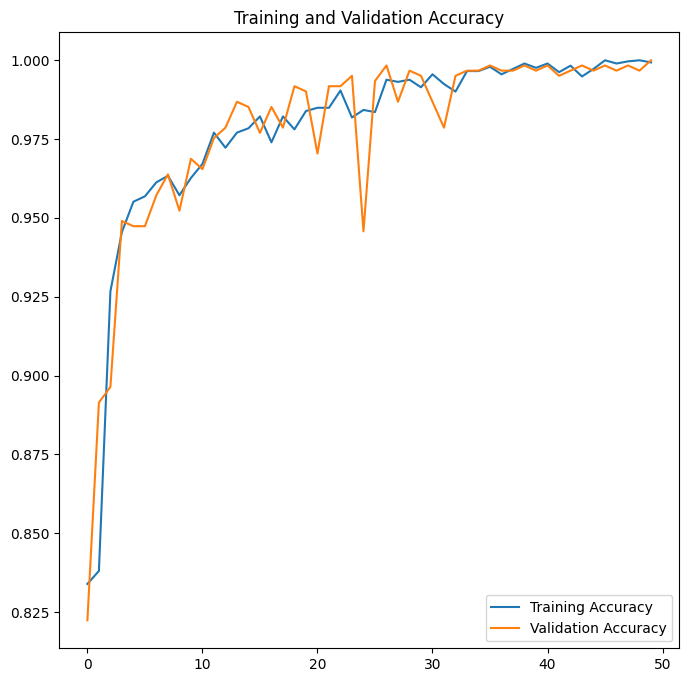

In [21]:
plt.figure(figsize=(8, 8))

plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

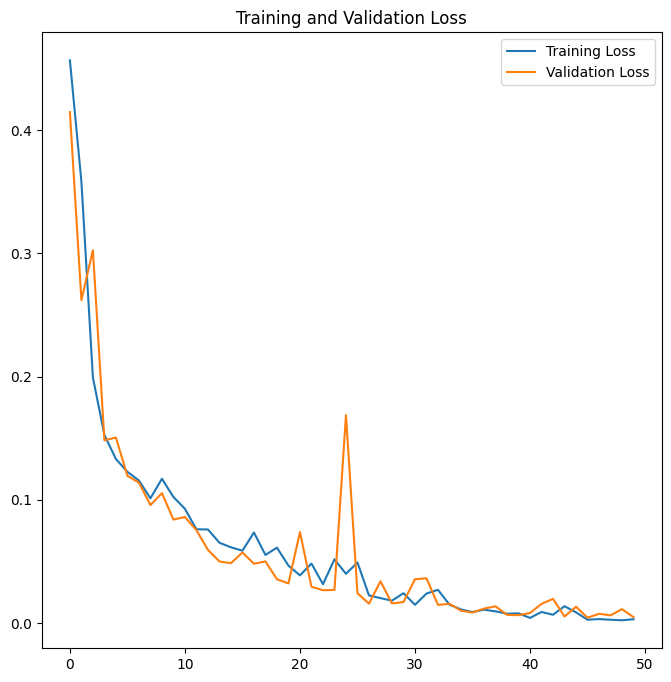

In [22]:
plt.figure(figsize=(8, 8))
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tuberculosis
1/1 [==============================] - 0s 250ms/step
predicted label: Tuberculosis


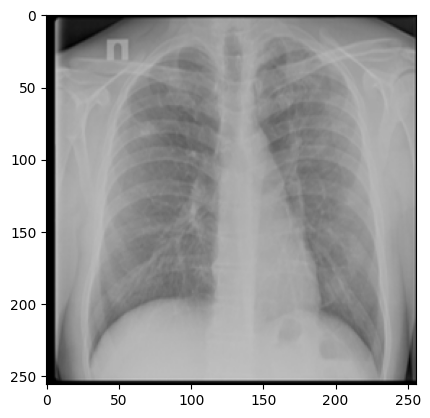

In [23]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 30ms/step


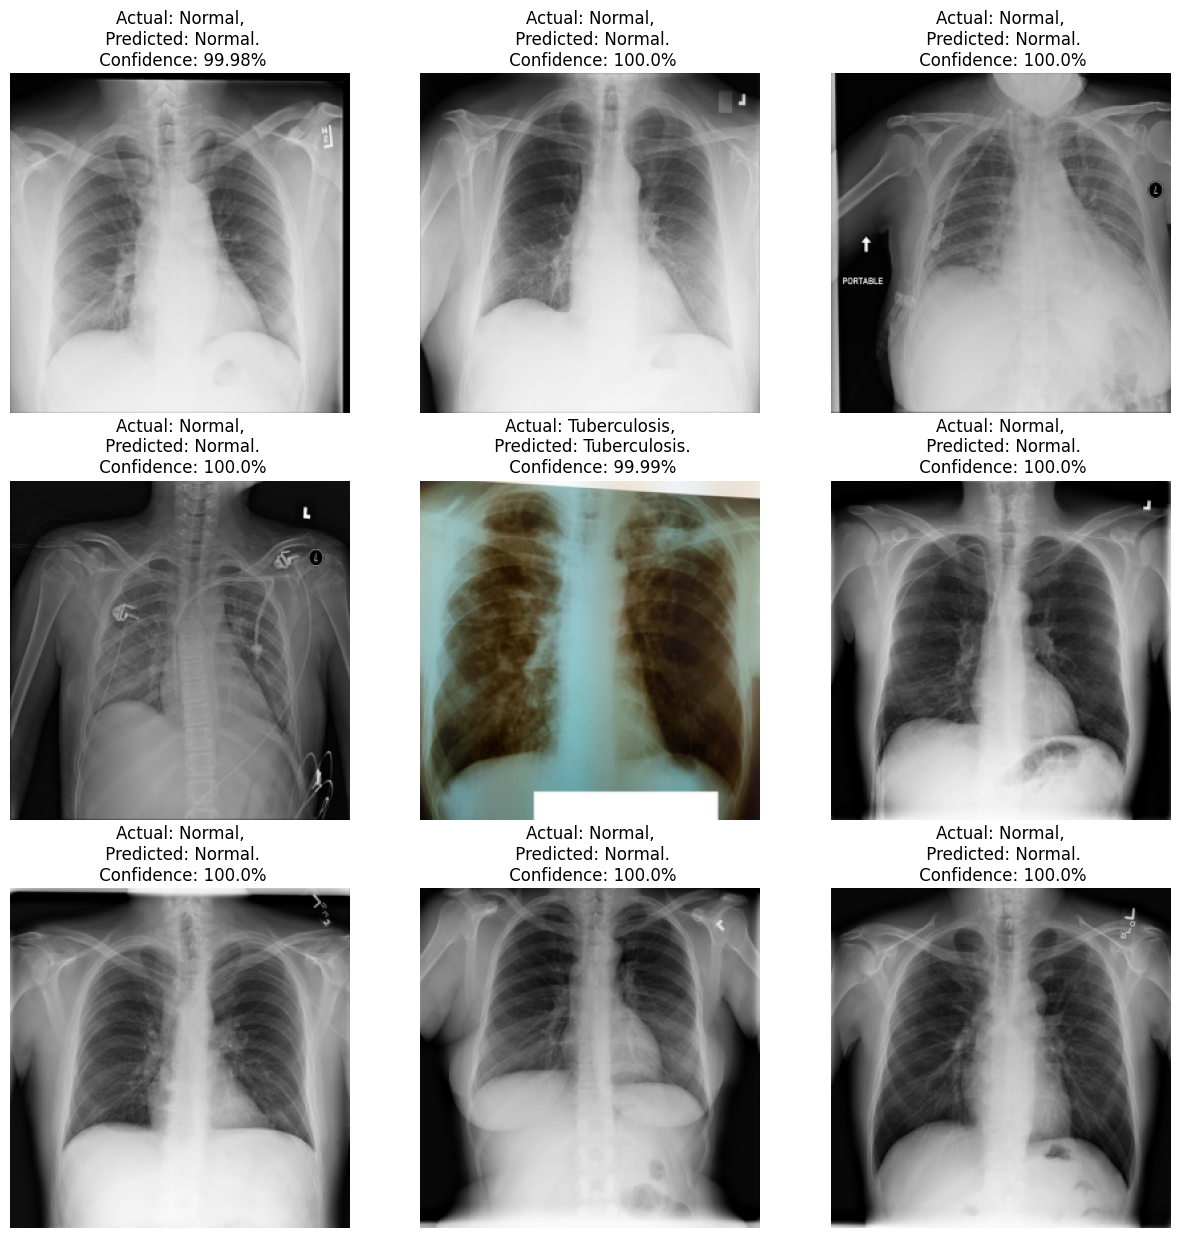

In [25]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [26]:
model.save("first.h5")